Car Price Prediction using Random Forest Regression

In [103]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [104]:
path = 'CarPrice_Assignment.csv'
data = pd.read_csv('CarPrice_Assignment.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [105]:
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [106]:
#helper function to calculate different errors
def error_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    errors = {}
    
    # Errors for train data
    errors["Train_MAE"] = mean_absolute_error(y_train_true, y_train_pred)
    errors["Train_MSE"] = mean_squared_error(y_train_true, y_train_pred)
    errors["Train_RMSE"] = np.sqrt(errors["Train_MSE"])
    errors["Train_R2_Score"] = r2_score(y_train_true, y_train_pred)
    
    # Errors for test data
    errors["Test_MAE"] = mean_absolute_error(y_test_true, y_test_pred)
    errors["Test_MSE"] = mean_squared_error(y_test_true, y_test_pred)
    errors["Test_RMSE"] = np.sqrt(errors["Test_MSE"])
    errors["Test_R2_Score"] = r2_score(y_test_true, y_test_pred)
    
    return errors

In [107]:
#Data Preprocessing
data.drop(columns = ['car_ID', 'symboling', 'CarName'], inplace = True)

#map doornumber and cylinder strings to numerical values
data['doornumber'] = data['doornumber'].replace({'four': 4, 'two': 2})
data['cylindernumber'] = data['cylindernumber'].map({'four': 4, 'five': 5, 'six': 6})

#one-hot-encoding
categorical_data = ['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation', 'fuelsystem', 'enginetype']
car_data_encoded = pd.get_dummies(data, columns=categorical_data, drop_first=True)

car_data_encoded.head()

/var/folders/0g/s4bqhs2x3zv2qlvlgz5xk5lc0000gn/T/ipykernel_72228/3579670752.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['doornumber'] = data['doornumber'].replace({'four': 4, 'two': 2})


,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,...,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,2,88.6,168.8,64.1,48.8,2548,4.0,130,3.47,2.68,...,False,True,False,False,False,False,False,False,False,False
1,2,88.6,168.8,64.1,48.8,2548,4.0,130,3.47,2.68,...,False,True,False,False,False,False,False,False,False,False
2,2,94.5,171.2,65.5,52.4,2823,6.0,152,2.68,3.47,...,False,True,False,False,False,False,False,False,True,False
3,4,99.8,176.6,66.2,54.3,2337,4.0,109,3.19,3.40,...,False,True,False,False,False,False,True,False,False,False
4,4,99.4,176.6,66.4,54.3,2824,5.0,136,3.19,3.40,...,False,True,False,False,False,False,True,False,False,False


In [108]:
#train and test splits
X = car_data_encoded.drop(columns=['price'])
y = car_data_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [112]:
#random forest
random_forest = RandomForestRegressor(random_state=42, n_estimators=100, criterion='squared_error', max_depth=6)
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

In [113]:
#evaluate model
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

error_random_forest = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_random_forest['Model Name'] = 'Random Forest'
error_random_forest

{'Train_MAE': np.float64(814.9699185326294),
 'Train_MSE': np.float64(1378769.5684009686),
 'Train_RMSE': np.float64(1174.2101891914278),
 'Train_R2_Score': 0.976880959658599,
 'Test_MAE': np.float64(1348.5114689672591),
 'Test_MSE': np.float64(3585077.9048029496),
 'Test_RMSE': np.float64(1893.4301953869199),
 'Test_R2_Score': 0.9545870875988437,
 'Model Name': 'Random Forest'}

Text(0.5, 1.0, 'Actual vs Expected Prices')

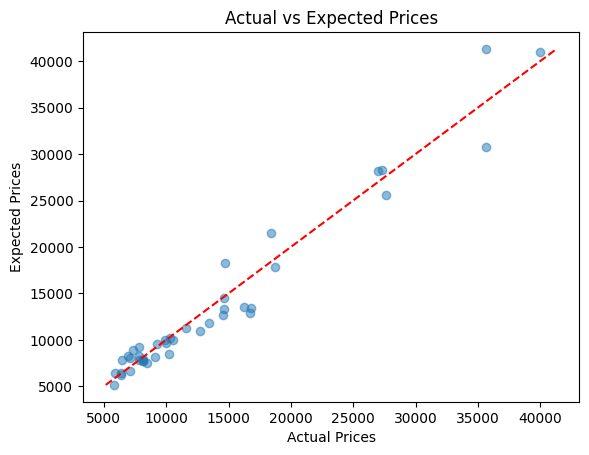

In [114]:
#model metrics

plt.scatter(y_test_pred, y_test, alpha = 0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.ylabel('Expected Prices')
plt.xlabel('Actual Prices')
plt.title('Actual vs Expected Prices')